In [ ]:
! pip install transformers datasets
! pip install rouge-score nltk evaluate
! pip install -U datasets huggingface_hub fsspec
!pip install evaluate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=8dccc94c30275eb27b649a382df7ad388091b98c2371c75c83e66715bc0faf19
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


In [ ]:
import os, sys
import argparse
import math
import time
import datetime
from google.colab import drive
import pickle
import json
import evaluate
import re
import pandas as pd
import seaborn as sns
import numpy as np
import random
from torch.nn import functional as F
from itertools import chain
import matplotlib.pyplot as plt

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler, TensorDataset
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import get_linear_schedule_with_warmup

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import glob

import nltk
nltk.download('punkt')

import torch.nn as nn

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    print("TensorBoard not available, training will continue without logging")
    class SummaryWriter:
        def __init__(self, *args, **kwargs): pass
        def add_scalar(self, *args, **kwargs): pass
        def add_scalars(self, *args, **kwargs): pass
        def close(self): pass

"""
Automatic Therapy Model Evaluation
Compare generated responses against test dataset ground truth
"""

try:
    import evaluate
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    from sklearn.metrics import accuracy_score, f1_score, classification_report
    import nltk
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt')
except ImportError:
    print("pip install evaluate nltk scikit-learn")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


DEBUGGING SETUP (NO EMOTION GENERATION)
Data files:
   train.json - MISSING
   val.json - MISSING

Processed files:
   train_processed_4thFIXED.pkl - Will be created
   val_processed_4thFIXED.pkl - Will be created

Tokenizer directories:
   train_processed_4thFIXED_tokenizer - Will be created

Checkpoint directories:
   therapy_checkpoints_4thFIXED - Will be created
Starting therapy AI training WITHOUT emotion generation
Model: gpt2
Batch size: 32, Epochs: 20
Learning rate: 2e-05, Max length: 128
Train data: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/train.json, Val data: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/val.json
Checkpoint dir: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions
Using device: cuda
Loading processed data from /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/train_processed_no_emotion_v1.pkl...
Loaded 3586 training examples
Filtering stats: 135/3721 sequences filtered out (96.4% retention

Epoch 0: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=4]


Training Loss: 4.8245


Validating: 100%|██████████| 14/14 [00:01<00:00, 12.99it/s]


Validation Loss: 4.1714
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_0.ckpt
New best model saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/best_model.ckpt

Epoch 1/19


Epoch 1: 100%|██████████| 113/113 [00:25<00:00,  4.35it/s, loss=2.91]


Training Loss: 4.0077


Validating: 100%|██████████| 14/14 [00:01<00:00, 12.85it/s]


Validation Loss: 3.6802
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_1.ckpt
New best model saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/best_model.ckpt

Epoch 2/19


Epoch 2: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=3.6]


Training Loss: 3.3601


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.01it/s]


Validation Loss: 3.0770
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_2.ckpt
New best model saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/best_model.ckpt

Epoch 3/19


Epoch 3: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=1.74]


Training Loss: 2.7507


Validating: 100%|██████████| 14/14 [00:01<00:00, 12.98it/s]


Validation Loss: 2.7466
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_3.ckpt
New best model saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/best_model.ckpt

Epoch 4/19


Epoch 4: 100%|██████████| 113/113 [00:25<00:00,  4.37it/s, loss=2.1]


Training Loss: 2.4816


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.02it/s]


Validation Loss: 2.7149
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_4.ckpt
New best model saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/best_model.ckpt

Epoch 5/19


Epoch 5: 100%|██████████| 113/113 [00:25<00:00,  4.37it/s, loss=1.64]


Training Loss: 2.3387


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.03it/s]


Validation Loss: 2.7255
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_5.ckpt

Epoch 6/19


Epoch 6: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=2.53]


Training Loss: 2.2421


Validating: 100%|██████████| 14/14 [00:01<00:00, 12.98it/s]


Validation Loss: 2.7429
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_6.ckpt

Epoch 7/19


Epoch 7: 100%|██████████| 113/113 [00:25<00:00,  4.37it/s, loss=2.03]


Training Loss: 2.1513


Validating: 100%|██████████| 14/14 [00:01<00:00, 12.91it/s]


Validation Loss: 2.7677
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_7.ckpt

Epoch 8/19


Epoch 8: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=3.04]


Training Loss: 2.0783


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.06it/s]


Validation Loss: 2.7994
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_8.ckpt

Epoch 9/19


Epoch 9: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=2.13]


Training Loss: 2.0045


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.07it/s]


Validation Loss: 2.8201
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_9.ckpt

Epoch 10/19


Epoch 10: 100%|██████████| 113/113 [00:25<00:00,  4.37it/s, loss=1.45]


Training Loss: 1.9371


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.07it/s]


Validation Loss: 2.8558
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_10.ckpt

Epoch 11/19


Epoch 11: 100%|██████████| 113/113 [00:25<00:00,  4.37it/s, loss=2.06]


Training Loss: 1.8859


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.10it/s]


Validation Loss: 2.8831
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_11.ckpt

Epoch 12/19


Epoch 12: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=1.67]


Training Loss: 1.8304


Validating: 100%|██████████| 14/14 [00:01<00:00, 12.97it/s]


Validation Loss: 2.9066
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_12.ckpt

Epoch 13/19


Epoch 13: 100%|██████████| 113/113 [00:25<00:00,  4.37it/s, loss=1.88]


Training Loss: 1.7960


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.04it/s]


Validation Loss: 2.9387
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_13.ckpt

Epoch 14/19


Epoch 14: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=1.36]


Training Loss: 1.7563


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.07it/s]


Validation Loss: 2.9576
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_14.ckpt

Epoch 15/19


Epoch 15: 100%|██████████| 113/113 [00:25<00:00,  4.35it/s, loss=1.44]


Training Loss: 1.7186


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.09it/s]


Validation Loss: 2.9995
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_15.ckpt

Epoch 16/19


Epoch 16: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=1.82]


Training Loss: 1.6986


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.11it/s]


Validation Loss: 3.0095
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_16.ckpt

Epoch 17/19


Epoch 17: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=1.52]


Training Loss: 1.6741


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.04it/s]


Validation Loss: 3.0309
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_17.ckpt

Epoch 18/19


Epoch 18: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=2.47]


Training Loss: 1.6707


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.04it/s]


Validation Loss: 3.0376
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_18.ckpt

Epoch 19/19


Epoch 19: 100%|██████████| 113/113 [00:25<00:00,  4.36it/s, loss=1.94]


Training Loss: 1.6573


Validating: 100%|██████████| 14/14 [00:01<00:00, 13.05it/s]


Validation Loss: 3.0393
Checkpoint saved: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions/epoch_19.ckpt
Training completed!
Loading TensorBoard data from /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/logs...
Loading from: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/logs/events.out.tfevents.1756067462.ca63e9cb3d6a.3083.2
Available metrics: ['Loss/train', 'PPL/train', 'Loss/valid', 'PPL/valid']
Loaded data for 4 metrics


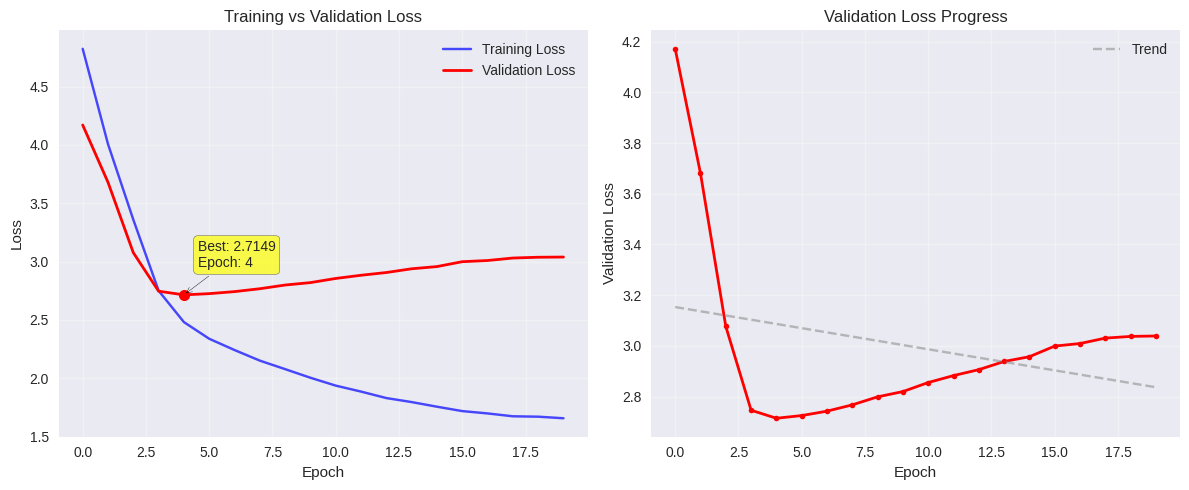

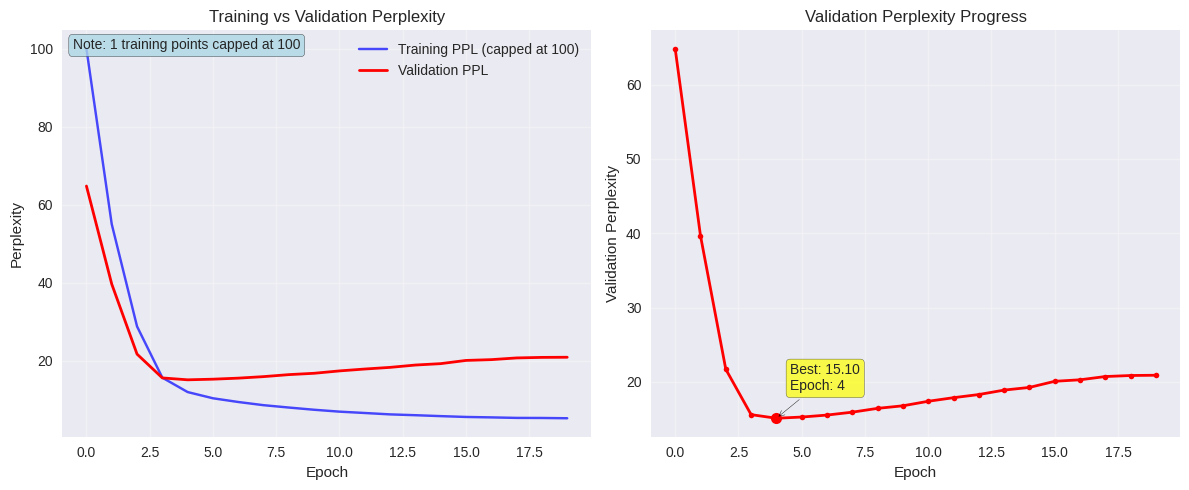


THERAPY AI TRAINING SUMMARY (NO EMOTION GENERATION)
Total Training Epochs: 20
Best Validation Loss: 2.7149 (Epoch 4)
Best Validation Perplexity: 15.10 (Epoch 4)
Training Trend: May Have Converged
Total Loss Reduction: 27.1%
High Training Perplexity Points: 1 (indicates some difficult sequences)


In [ ]:


# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class Args:
    """Simple args class for Colab"""
    def __init__(self):
        self.seed = 42
        self.gpu = "0"
        self.warmup_ratio = 0.1
        self.num_workers = 0

        self.model_type = None
        self.lr = None
        self.batch_size = None
        self.num_epochs = None
        self.max_len = None
        self.ckpt_dir = None
        self.ckpt_name = None
        self.train_data = None
        self.val_data = None

def dataset_loader_no_emotion_v1(data_path='', save_path='therapy_processed_no_emotion_v1.pkl', max_length=128):
    """
    NO therapist emotion generation
    """

    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    emotion_tokens = [
        "anger", "sadness", "depression", "disgust", "fear", "joy", "neutral"
    ]

    special_tokens = {
        'bos_token': "<bos>",
        'eos_token': "<eos>",
        'pad_token': "<pad>",
        'additional_special_tokens': [
            "<problem>",
            "<user>",
            "<user_emotion>",
            "<therapist>",
            "<therapist_emotion>"
        ] + emotion_tokens
    }

    num_new_tokens = tokenizer.add_special_tokens(special_tokens)
    print(f"Added {num_new_tokens} special tokens")
    print(f"Emotion tokens added: {emotion_tokens}")

    print(f"Verifying emotion tokenization:")
    for emotion in emotion_tokens:
        tokens = tokenizer.encode(emotion, add_special_tokens=False)
        decoded = tokenizer.decode(tokens[0]) if tokens else "ERROR"
        print(f"   '{emotion}' -> Token ID: {tokens[0] if tokens else 'N/A'} -> '{decoded}'")

    bos_id = tokenizer.bos_token_id
    eos_id = tokenizer.eos_token_id
    pad_id = tokenizer.pad_token_id
    problem_id = tokenizer.convert_tokens_to_ids("<problem>")
    user_id = tokenizer.convert_tokens_to_ids("<user>")
    user_emotion_id = tokenizer.convert_tokens_to_ids("<user_emotion>")
    therapist_id = tokenizer.convert_tokens_to_ids("<therapist>")
    therapist_emotion_id = tokenizer.convert_tokens_to_ids("<therapist_emotion>")

    print(f"Key token IDs:")
    print(f"   <therapist>: {therapist_id}")
    print(f"   <therapist_emotion>: {therapist_emotion_id}")
    print(f"   <eos>: {eos_id}")

    input_ids_list = []
    attention_mask_list = []
    labels_list = []
    dialogue_lengths = []

    total_sequences = 0
    filtered_sequences = 0

    try:
        with open(data_path, 'r') as f:
            data = json.load(f)
        print(f"Successfully loaded JSON file with {len(data)} conversations")
    except Exception as e:
        print(f"Error loading JSON file: {e}")
        return None

    print(f"Processing {len(data)} therapy conversations...")
    total_examples = 0

    for conversation_idx, conversation in enumerate(tqdm(data, desc="Processing conversations")):
        try:
            problem_type = conversation.get("problem_type", "").strip()
            dialog = conversation.get("dialog", [])

            if not dialog:
                continue

            i = 0
            while i < len(dialog):
                conversation_turns = []

                # Collect user turns
                while i < len(dialog) and dialog[i].get("speaker") != "sys":
                    conversation_turns.append(dialog[i])
                    i += 1

                # Process therapist response
                if i < len(dialog) and dialog[i].get("speaker") == "sys":
                    therapist_turn = dialog[i]

                    if conversation_turns:
                        try:
                            combined_text_parts = []
                            user_emotions = []

                            for turn in conversation_turns:
                                turn_text = turn.get("text", "").strip()
                                turn_emotion = turn.get("emotion", "").strip()

                                if turn_text:
                                    # Clean descriptive text
                                    expression_pattern = r'\s*(The (?:speaker|emotion state)[^.]*\.(?:[^.]*\.)*)'
                                    match = re.search(expression_pattern, turn_text, re.IGNORECASE | re.DOTALL)

                                    if match:
                                        clean_text = turn_text[:match.start()].strip()
                                    else:
                                        clean_text = turn_text

                                    if clean_text:
                                        combined_text_parts.append(clean_text)

                                if turn_emotion:
                                    user_emotions.append(turn_emotion)

                            # Combine user data
                            user_text = " ".join(combined_text_parts)
                            user_emotion = user_emotions[0] if user_emotions else ""

                            # Process therapist data
                            therapist_full_text = therapist_turn.get("text", "").strip()
                            therapist_emotion = therapist_turn.get("emotion", "").strip()

                            # Clean therapist text
                            expression_pattern = r'\s*(The (?:speaker|emotion state)[^.]*\.(?:[^.]*\.)*)'
                            therapist_match = re.search(expression_pattern, therapist_full_text, re.IGNORECASE | re.DOTALL)

                            if therapist_match:
                                therapist_text = therapist_full_text[:therapist_match.start()].strip()
                            else:
                                therapist_text = therapist_full_text

                            if not user_text or not therapist_text:
                                i += 1
                                continue

                            if total_examples < 3:
                                print(f"\nSample {total_examples + 1}:")
                                print(f"   User: {user_text[:50]}{'...' if len(user_text) > 50 else ''}")
                                print(f"   User Emotion: {user_emotion}")
                                print(f"   Therapist: {therapist_text}")
                                print(f"   Therapist Emotion: {therapist_emotion} (NOT GENERATED)")
                                print("-" * 60)

                            problem_tokens = tokenizer.encode(problem_type, add_special_tokens=False) if problem_type else []
                            user_tokens = tokenizer.encode(user_text, add_special_tokens=False)
                            user_emotion_tokens = tokenizer.encode(user_emotion, add_special_tokens=False) if user_emotion else []
                            therapist_tokens = tokenizer.encode(therapist_text, add_special_tokens=False)
                            therapist_emotion_tokens = tokenizer.encode(therapist_emotion, add_special_tokens=False) if therapist_emotion else []

                            # Build input_ids sequence - NO THERAPIST EMOTION
                            input_ids = [bos_id]

                            if problem_tokens:
                                input_ids.extend([problem_id] + problem_tokens)

                            input_ids.extend([user_id] + user_tokens)

                            if user_emotion_tokens:
                                input_ids.extend([user_emotion_id] + user_emotion_tokens)

                            input_ids.extend([therapist_id] + therapist_tokens)

                            input_ids.append(eos_id)

                            total_sequences += 1

                            # Filter overly long sequences
                            if len(input_ids) > max_length:
                                filtered_sequences += 1
                                if total_sequences <= 5:
                                    print(f"Filtering sequence {total_sequences}: length {len(input_ids)} >= {max_length}")
                                i += 1
                                continue

                            # Create correct labels - NO THERAPIST EMOTION PREDICTION
                            labels = []

                            # BOS - don't predict
                            labels.append(-100)

                            # Problem section - don't predict
                            if problem_tokens:
                                labels.extend([-100] * (len([problem_id] + problem_tokens)))

                            # User section - don't predict
                            labels.extend([-100] * (len([user_id] + user_tokens)))

                            # User emotion section - don't predict
                            if user_emotion_tokens:
                                labels.extend([-100] * (len([user_emotion_id] + user_emotion_tokens)))

                            # Therapist section: don't predict <therapist>, predict text content
                            labels.append(-100)  # <therapist> tag - don't predict
                            labels.extend(therapist_tokens)  # therapist text content - predict


                            # EOS - predict
                            labels.append(eos_id)

                            if len(input_ids) != len(labels):
                                print(f"Length mismatch: {len(input_ids)} vs {len(labels)}")
                                print(f"   Input sequence: {tokenizer.decode(input_ids, skip_special_tokens=False)}")
                                i += 1
                                continue

                            if total_examples < 2:
                                print(f"\nSample {total_examples + 1} Labels Debug:")
                                therapist_start = None

                                for idx, (token_id, label) in enumerate(zip(input_ids, labels)):
                                    token_str = tokenizer.decode([token_id])
                                    if token_id == therapist_id:
                                        therapist_start = idx
                                        print(f"   {idx}: {token_str} -> Label: {label} (don't predict)")
                                    elif therapist_start is not None and label != -100:
                                        print(f"   {idx}: {token_str} -> Label: {label} (predict)")

                                prediction_tokens = [l for l in labels if l != -100]
                                prediction_text = tokenizer.decode(prediction_tokens, skip_special_tokens=False)
                                print(f"   Prediction target: {prediction_text}")

                            # Create attention mask
                            attention_mask = [1] * len(input_ids)

                            # Padding
                            if len(input_ids) < max_length:
                                pad_length = max_length - len(input_ids)
                                input_ids.extend([pad_id] * pad_length)
                                attention_mask.extend([0] * pad_length)
                                labels.extend([-100] * pad_length)

                            input_ids_list.append(input_ids)
                            attention_mask_list.append(attention_mask)
                            labels_list.append(labels)
                            dialogue_lengths.append(len(therapist_tokens))  # Only therapist text length
                            total_examples += 1

                        except Exception as e:
                            print(f"Error processing conversation {conversation_idx}, sample {total_examples}: {e}")
                            i += 1
                            continue

                i += 1

        except Exception as e:
            print(f"Error processing conversation {conversation_idx}: {e}")
            continue

        if (conversation_idx + 1) % 10 == 0:
            retention_rate = ((total_sequences - filtered_sequences) / total_sequences * 100) if total_sequences > 0 else 0
            print(f"Created {total_examples} samples, filtered {filtered_sequences}/{total_sequences}({retention_rate:.1f}% retention)")

    processed_count = len(input_ids_list)
    retention_rate = ((total_sequences - filtered_sequences) / total_sequences * 100) if total_sequences > 0 else 0

    if dialogue_lengths:
        mean_response_len = np.mean(dialogue_lengths)
        median_response_len = np.median(dialogue_lengths)
        max_response_len = np.max(dialogue_lengths)
        min_response_len = np.min(dialogue_lengths)
    else:
        mean_response_len = median_response_len = max_response_len = min_response_len = 0

    print(f"\nPREPROCESSING COMPLETE")
    print(f"Total sequences processed: {total_sequences}")
    print(f"Sequences filtered out (>= {max_length} tokens): {filtered_sequences}")
    print(f"Successfully created {processed_count} training samples")
    print(f"Retention rate: {retention_rate:.1f}%")
    print(f"Therapist response lengths (text only, NO emotion tags):")
    print(f"    Mean: {mean_response_len:.2f} tokens")
    print(f"    Median: {median_response_len:.2f} tokens")
    print(f"    Min: {min_response_len} tokens")
    print(f"    Max: {max_response_len} tokens")

    if processed_count == 0:
        print("No valid training samples created!")
        return None

    processed_data = {
        'input_ids': input_ids_list,
        'attention_mask': attention_mask_list,
        'labels': labels_list,
        'tokenizer_vocab_size': len(tokenizer),
        'special_tokens': special_tokens,
        'stats': {
            'total_conversations': len(data),
            'total_sequences_processed': total_sequences,
            'sequences_filtered': filtered_sequences,
            'total_examples': processed_count,
            'retention_rate': retention_rate,
            'max_length_used': max_length,
            'mean_response_length': mean_response_len,
            'preprocessing_version': 'no_emotion_generation_v1'
        }
    }

    with open(save_path, 'wb') as f:
        pickle.dump(processed_data, f)

    print(f"Saved processed data to {save_path}")

    # Save tokenizer
    tokenizer_save_path = save_path.replace('.pkl', '_tokenizer')
    tokenizer.save_pretrained(tokenizer_save_path)
    print(f"Saved tokenizer to {tokenizer_save_path}")

    return tokenizer

class TherapyDataset(Dataset):
    def __init__(self, data_path):
        print(f"Loading processed data from {data_path}...")
        with open(data_path, 'rb') as f:
            self.data = pickle.load(f)

        self.input_ids = self.data['input_ids']
        self.attention_mask = self.data['attention_mask']
        self.labels = self.data['labels']

        print(f"Loaded {len(self.input_ids)} training examples")

        if 'stats' in self.data:
            stats = self.data['stats']
            if 'total_sequences_processed' in stats and 'sequences_filtered' in stats:
                total = stats['total_sequences_processed']
                filtered = stats['sequences_filtered']
                retention = stats.get('retention_rate', 0)
                print(f"Filtering stats: {filtered}/{total} sequences filtered out ({retention:.1f}% retention)")

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class NoEmotionTrainerV1:
    def __init__(self, args, train_data_path, val_data_path):
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Set random seed
        torch.manual_seed(args.seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(args.seed)

        # Process data if needed
        train_processed_path = f"/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/train_processed_no_emotion_v1.pkl"
        val_processed_path = f"/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/val_processed_no_emotion_v1.pkl"

        if not os.path.exists(train_processed_path):
            print("Processing training data...")
            dataset_loader_no_emotion_v1(train_data_path, train_processed_path, args.max_len)

        if not os.path.exists(val_processed_path):
            print("Processing validation data...")
            dataset_loader_no_emotion_v1(val_data_path, val_processed_path, args.max_len)

        # Load datasets
        self.train_dataset = TherapyDataset(train_processed_path)
        self.val_dataset = TherapyDataset(val_processed_path)

        # Load tokenizer
        tokenizer_path = train_processed_path.replace('.pkl', '_tokenizer')
        self.tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)

        # Initialize model
        self.model = GPT2LMHeadModel.from_pretrained(args.model_type)
        self.model.resize_token_embeddings(len(self.tokenizer))
        self.model.to(self.device)

        # Create data loaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=args.num_workers
        )

        self.val_loader = DataLoader(
            self.val_dataset,
            batch_size=args.batch_size,
            shuffle=False,
            num_workers=args.num_workers
        )

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=args.lr)

        total_steps = len(self.train_loader) * args.num_epochs
        warmup_steps = int(total_steps * args.warmup_ratio)

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        os.makedirs(args.ckpt_dir, exist_ok=True)
        log_dir = f"/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/logs"
        os.makedirs(log_dir, exist_ok=True)

        self.writer = SummaryWriter(log_dir=log_dir)

        self.best_val_loss = float('inf')
        self.start_epoch = 0

        if args.ckpt_name:
            self.load_checkpoint(args.ckpt_name)

    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0

        progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch}")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()

            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = total_loss / len(self.train_loader)

        self.writer.add_scalar('Loss/train', avg_loss, epoch)
        self.writer.add_scalar('PPL/train', np.exp(avg_loss), epoch)

        return avg_loss

    def validate(self, epoch):
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validating"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_loss += outputs.loss.item()

        avg_loss = total_loss / len(self.val_loader)

        # Log metrics
        self.writer.add_scalar('Loss/valid', avg_loss, epoch)
        self.writer.add_scalar('PPL/valid', np.exp(avg_loss), epoch)

        return avg_loss

    def save_checkpoint(self, epoch, val_loss):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'val_loss': val_loss,
            'tokenizer_vocab_size': len(self.tokenizer)
        }

        checkpoint_path = os.path.join(self.args.ckpt_dir, f"epoch_{epoch}.ckpt")
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

        # Save best model
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            best_path = os.path.join(self.args.ckpt_dir, "best_model.ckpt")
            torch.save(checkpoint, best_path)
            print(f"New best model saved: {best_path}")

    def load_checkpoint(self, checkpoint_name):
        checkpoint_path = os.path.join(self.args.ckpt_dir, checkpoint_name)
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=self.device)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            self.start_epoch = checkpoint['epoch'] + 1
            self.best_val_loss = checkpoint.get('val_loss', float('inf'))
            print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
        else:
            print(f"Checkpoint {checkpoint_path} not found")

    def train_with_validation(self):
        print("Starting training...")

        for epoch in range(self.start_epoch, self.args.num_epochs):
            print(f"\nEpoch {epoch}/{self.args.num_epochs-1}")

            # Training
            train_loss = self.train_epoch(epoch)
            print(f"Training Loss: {train_loss:.4f}")

            # Validation
            val_loss = self.validate(epoch)
            print(f"Validation Loss: {val_loss:.4f}")

            self.save_checkpoint(epoch, val_loss)

        self.writer.close()
        print("Training completed!")

class TrainingVisualiserNoEmotion:
    def __init__(self, log_dir="/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/logs"):
        self.log_dir = log_dir
        self.data = {}
        self.load_tensorboard_data()

    def load_tensorboard_data(self):
        print(f"Loading TensorBoard data from {self.log_dir}...")

        event_files = glob.glob(os.path.join(self.log_dir, "events.out.tfevents.*"))

        if not event_files:
            print(f"No TensorBoard event files found in {self.log_dir}")
            return

        latest_file = max(event_files, key=os.path.getctime)
        print(f"Loading from: {latest_file}")

        ea = EventAccumulator(latest_file)
        ea.Reload()

        scalar_tags = ea.Tags()['scalars']
        print(f"Available metrics: {scalar_tags}")

        for tag in scalar_tags:
            scalar_events = ea.Scalars(tag)
            steps = [event.step for event in scalar_events]
            values = [event.value for event in scalar_events]

            self.data[tag] = {
                'steps': steps,
                'values': values
            }

        print(f"Loaded data for {len(self.data)} metrics")

    def plot_loss_curves(self, figsize=(12, 5), save_path=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        if 'Loss/train' in self.data and 'Loss/valid' in self.data:
            train_steps = self.data['Loss/train']['steps']
            train_loss = self.data['Loss/train']['values']
            valid_steps = self.data['Loss/valid']['steps']
            valid_loss = self.data['Loss/valid']['values']

            ax1.plot(train_steps, train_loss, 'b-', label='Training Loss', alpha=0.7)
            ax1.plot(valid_steps, valid_loss, 'r-', label='Validation Loss', linewidth=2)
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.set_title('Training vs Validation Loss')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # Highlight best validation loss
            best_idx = np.argmin(valid_loss)
            best_epoch = valid_steps[best_idx]
            best_loss = valid_loss[best_idx]
            ax1.plot(best_epoch, best_loss, 'ro', markersize=8, label=f'Best Val Loss: {best_loss:.4f}')
            ax1.annotate(f'Best: {best_loss:.4f}\nEpoch: {best_epoch}',
                        xy=(best_epoch, best_loss), xytext=(10, 20),
                        textcoords='offset points', ha='left',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        if 'Loss/valid' in self.data:
            valid_steps = self.data['Loss/valid']['steps']
            valid_loss = self.data['Loss/valid']['values']

            ax2.plot(valid_steps, valid_loss, 'r-', linewidth=2, marker='o', markersize=4)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Validation Loss')
            ax2.set_title('Validation Loss Progress')
            ax2.grid(True, alpha=0.3)

            if len(valid_steps) > 1:
                z = np.polyfit(valid_steps, valid_loss, 1)
                p = np.poly1d(z)
                ax2.plot(valid_steps, p(valid_steps), '--', alpha=0.5, color='gray', label='Trend')
                ax2.legend()

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Loss curves saved to {save_path}")

        plt.show()

    def plot_perplexity_curves(self, figsize=(12, 5), max_ppl=100, save_path=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Plot 1: Training vs Validation Perplexity (Capped)
        if 'PPL/train' in self.data and 'PPL/valid' in self.data:
            train_steps = self.data['PPL/train']['steps']
            train_ppl = np.array(self.data['PPL/train']['values'])
            valid_steps = self.data['PPL/valid']['steps']
            valid_ppl = np.array(self.data['PPL/valid']['values'])

            train_ppl_capped = np.minimum(train_ppl, max_ppl)

            ax1.plot(train_steps, train_ppl_capped, 'b-', label=f'Training PPL (capped at {max_ppl})', alpha=0.7)
            ax1.plot(valid_steps, valid_ppl, 'r-', label='Validation PPL', linewidth=2)
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Perplexity')
            ax1.set_title('Training vs Validation Perplexity')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            capped_count = np.sum(train_ppl > max_ppl)
            if capped_count > 0:
                ax1.text(0.02, 0.98, f'Note: {capped_count} training points capped at {max_ppl}',
                        transform=ax1.transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        if 'PPL/valid' in self.data:
            valid_steps = self.data['PPL/valid']['steps']
            valid_ppl = self.data['PPL/valid']['values']

            ax2.plot(valid_steps, valid_ppl, 'r-', linewidth=2, marker='o', markersize=4)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Validation Perplexity')
            ax2.set_title('Validation Perplexity Progress')
            ax2.grid(True, alpha=0.3)

            best_idx = np.argmin(valid_ppl)
            best_epoch = valid_steps[best_idx]
            best_ppl = valid_ppl[best_idx]
            ax2.plot(best_epoch, best_ppl, 'ro', markersize=8)
            ax2.annotate(f'Best: {best_ppl:.2f}\nEpoch: {best_epoch}',
                        xy=(best_epoch, best_ppl), xytext=(10, 20),
                        textcoords='offset points', ha='left',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Perplexity curves saved to {save_path}")

        plt.show()

    def create_training_summary(self):
        """Create a comprehensive training summary"""

        print("\n" + "="*60)
        print("THERAPY AI TRAINING SUMMARY (NO EMOTION GENERATION)")
        print("="*60)

        if not self.data:
            print("No training data available")
            return

        # Training epochs
        if 'Loss/train' in self.data:
            total_epochs = len(self.data['Loss/train']['steps'])
            print(f"Total Training Epochs: {total_epochs}")

        # Best validation metrics
        if 'Loss/valid' in self.data:
            valid_losses = self.data['Loss/valid']['values']
            best_loss_idx = np.argmin(valid_losses)
            best_loss = valid_losses[best_loss_idx]
            best_loss_epoch = self.data['Loss/valid']['steps'][best_loss_idx]
            print(f"Best Validation Loss: {best_loss:.4f} (Epoch {best_loss_epoch})")

        if 'PPL/valid' in self.data:
            valid_ppls = self.data['PPL/valid']['values']
            best_ppl_idx = np.argmin(valid_ppls)
            best_ppl = valid_ppls[best_ppl_idx]
            best_ppl_epoch = self.data['PPL/valid']['steps'][best_ppl_idx]
            print(f"Best Validation Perplexity: {best_ppl:.2f} (Epoch {best_ppl_epoch})")

        # Training progression analysis
        if 'Loss/valid' in self.data and len(self.data['Loss/valid']['values']) >= 3:
            valid_losses = self.data['Loss/valid']['values']

            recent_losses = valid_losses[-3:]
            if recent_losses[-1] < recent_losses[0]:
                trend = "Still Improving"
            else:
                trend = "May Have Converged"

            print(f"Training Trend: {trend}")

            initial_loss = valid_losses[0]
            final_loss = valid_losses[-1]
            improvement = ((initial_loss - final_loss) / initial_loss) * 100
            print(f"Total Loss Reduction: {improvement:.1f}%")

        # Perplexity analysis
        if 'PPL/train' in self.data:
            train_ppls = np.array(self.data['PPL/train']['values'])
            high_ppl_count = np.sum(train_ppls > 100)
            if high_ppl_count > 0:
                print(f"High Training Perplexity Points: {high_ppl_count} (indicates some difficult sequences)")

        print("="*60)

def run_therapy_training_no_emotion_v1(
    train_data_file="train.json",
    val_data_file="val.json",
    model_type="gpt2",
    batch_size=32,
    num_epochs=20,
    learning_rate=2e-5,
    max_length=128,
    checkpoint_dir="/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/checkpoints_no_emotion_v1",
    resume_from=None
):
    """Run training with NO emotion generation"""
    args = Args()
    args.train_data = train_data_file
    args.val_data = val_data_file
    args.model_type = model_type
    args.batch_size = batch_size
    args.num_epochs = num_epochs
    args.lr = learning_rate
    args.max_len = max_length
    args.ckpt_dir = checkpoint_dir
    args.ckpt_name = resume_from

    valid_models = ["gpt2"]
    assert args.model_type in valid_models, f"Invalid model. Choose from: {valid_models}"

    print(f"Starting therapy AI training WITHOUT emotion generation")
    print(f"Model: {args.model_type}")
    print(f"Batch size: {args.batch_size}, Epochs: {args.num_epochs}")
    print(f"Learning rate: {args.lr}, Max length: {args.max_len}")
    print(f"Train data: {args.train_data}, Val data: {args.val_data}")
    print(f"Checkpoint dir: {args.ckpt_dir}")

    trainer = NoEmotionTrainerV1(args, train_data_path=args.train_data, val_data_path=args.val_data)
    trainer.train_with_validation()

    return trainer

def debug_setup_corrected():
    """Debug your current setup for corrected version"""
    print("DEBUGGING SETUP (NO EMOTION GENERATION)")
    print("="*50)

    # Check data files
    print("Data files:")
    for file in ['train.json', 'val.json']:
        if os.path.exists(file):
            size = os.path.getsize(file) / 1024
            print(f"   {file} ({size:.1f} KB)")
        else:
            print(f"   {file} - MISSING")

    # Check processed files
    print("\nProcessed files:")
    for file in ['train_processed_4thFIXED.pkl', 'val_processed_4thFIXED.pkl']:
        if os.path.exists(file):
            size = os.path.getsize(file) / (1024*1024)
            print(f"   {file} ({size:.1f} MB)")
        else:
            print(f"   {file} - Will be created")

    # Check tokenizer directories
    print("\nTokenizer directories:")
    for dir_name in ['train_processed_4thFIXED_tokenizer']:
        if os.path.exists(dir_name):
            files = os.listdir(dir_name)
            print(f"   {dir_name} ({len(files)} files)")
        else:
            print(f"   {dir_name} - Will be created")

    # Check checkpoint directories
    print("\nCheckpoint directories:")
    for dir_name in ['therapy_checkpoints_4thFIXED']:
        if os.path.exists(dir_name):
            files = [f for f in os.listdir(dir_name) if f.endswith('.ckpt')]
            print(f"   {dir_name} ({len(files)} checkpoints)")
        else:
            print(f"   {dir_name} - Will be created")

    return True

def validate_preprocessing_fix():
    """Validate that the preprocessing works correctly without emotion generation"""
    print("VALIDATING NO-EMOTION PREPROCESSING")
    print("="*50)

    try:
        # Load processed data
        with open('train_processed_4thFIXED.pkl', 'rb') as f:
            data = pickle.load(f)

        # Load tokenizer
        tokenizer = GPT2Tokenizer.from_pretrained('train_processed_4thFIXED_tokenizer')
        therapist_emotion_id = tokenizer.convert_tokens_to_ids("<therapist_emotion>")

        print(f"Dataset size: {len(data['input_ids'])}")
        print(f"<therapist_emotion> token ID: {therapist_emotion_id}")

        correct_samples = 0
        for i in range(min(3, len(data['input_ids']))):
            input_ids = data['input_ids'][i]
            labels = data['labels'][i]

            print(f"\nSample {i+1}:")

            # Decode full sequence
            full_sequence = tokenizer.decode(input_ids, skip_special_tokens=False)
            print(f"Input: {full_sequence}")

            has_emotion_in_input = therapist_emotion_id in input_ids
            print(f"Has <therapist_emotion> in input: {has_emotion_in_input}")

            prediction_tokens = [token_id for token_id, label in zip(input_ids, labels) if label != -100]
            prediction_text = tokenizer.decode(prediction_tokens, skip_special_tokens=False)
            print(f"Will predict: {prediction_text}")

            # Verify no emotion tags in prediction
            if "<therapist_emotion>" not in prediction_text and not has_emotion_in_input:
                print("✓ SUCCESS: No therapist emotion in input or prediction")
                correct_samples += 1
            else:
                print("✗ ERROR: Therapist emotion found")

        print(f"\nCorrect samples: {correct_samples}/3")
        return correct_samples == 3

    except FileNotFoundError:
        print("Processed files not found. Run preprocessing first.")
        return False
    except Exception as e:
        print(f"Error during validation: {e}")
        return False

# Usage example
if __name__ == "__main__":
    debug_setup_corrected()

    # Step 2: Run training
    trainer = run_therapy_training_no_emotion_v1(
        train_data_file="/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/train.json",
        val_data_file="/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/val.json",
        num_epochs=20,
        batch_size=32,
        checkpoint_dir="/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/therapy_checkpoints_4thFIXED_noemotions"
    )


Loading TensorBoard data from /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/logs...
Loading from: /content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/logs/events.out.tfevents.1756067462.ca63e9cb3d6a.3083.2
Available metrics: ['Loss/train', 'PPL/train', 'Loss/valid', 'PPL/valid']
Loaded data for 4 metrics
Applied +1 epoch offset (displaying as 1-20 instead of 0-19)


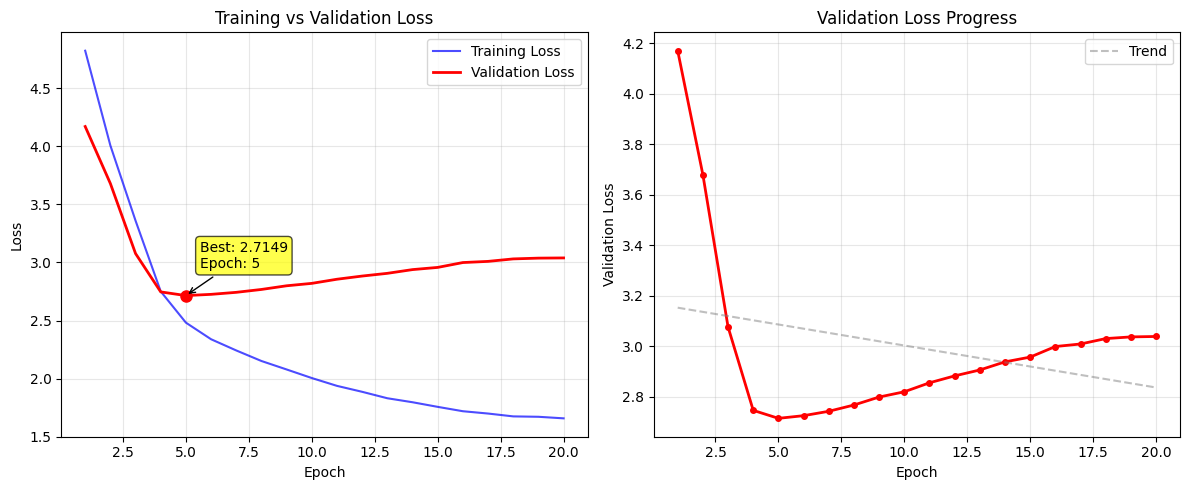

In [ ]:
class TrainingVisualiserNoEmotion:
    def __init__(self, log_dir="/content/drive/MyDrive/RL-SFT-GPT2 MentalHealth/SFTNoemotions/logs", offset_epochs=True):
        self.log_dir = log_dir
        self.offset_epochs = offset_epochs
        self.data = {}
        self.load_tensorboard_data()

    def load_tensorboard_data(self):
        print(f"Loading TensorBoard data from {self.log_dir}...")

        event_files = glob.glob(os.path.join(self.log_dir, "events.out.tfevents.*"))

        if not event_files:
            print(f"No TensorBoard event files found in {self.log_dir}")
            return

        latest_file = max(event_files, key=os.path.getctime)
        print(f"Loading from: {latest_file}")

        ea = EventAccumulator(latest_file)
        ea.Reload()

        scalar_tags = ea.Tags()['scalars']
        print(f"Available metrics: {scalar_tags}")

        for tag in scalar_tags:
            scalar_events = ea.Scalars(tag)
            steps = [event.step for event in scalar_events]
            values = [event.value for event in scalar_events]

            # Apply epoch offset if requested (0-19 -> 1-20)
            if self.offset_epochs:
                steps = [step + 1 for step in steps]

            self.data[tag] = {
                'steps': steps,
                'values': values
            }

        print(f"Loaded data for {len(self.data)} metrics")
        if self.offset_epochs:
            print("Applied +1 epoch offset (displaying as 1-20 instead of 0-19)")

    def plot_loss_curves(self, figsize=(12, 5), save_path=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        if 'Loss/train' in self.data and 'Loss/valid' in self.data:
            train_steps = self.data['Loss/train']['steps']
            train_loss = self.data['Loss/train']['values']
            valid_steps = self.data['Loss/valid']['steps']
            valid_loss = self.data['Loss/valid']['values']

            ax1.plot(train_steps, train_loss, 'b-', label='Training Loss', alpha=0.7)
            ax1.plot(valid_steps, valid_loss, 'r-', label='Validation Loss', linewidth=2)
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.set_title('Training vs Validation Loss')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            # Highlight best validation loss
            best_idx = np.argmin(valid_loss)
            best_epoch = valid_steps[best_idx]
            best_loss = valid_loss[best_idx]
            ax1.plot(best_epoch, best_loss, 'ro', markersize=8)
            ax1.annotate(f'Best: {best_loss:.4f}\nEpoch: {best_epoch}',
                        xy=(best_epoch, best_loss), xytext=(10, 20),
                        textcoords='offset points', ha='left',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        if 'Loss/valid' in self.data:
            valid_steps = self.data['Loss/valid']['steps']
            valid_loss = self.data['Loss/valid']['values']

            ax2.plot(valid_steps, valid_loss, 'r-', linewidth=2, marker='o', markersize=4)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Validation Loss')
            ax2.set_title('Validation Loss Progress')
            ax2.grid(True, alpha=0.3)

            if len(valid_steps) > 1:
                z = np.polyfit(valid_steps, valid_loss, 1)
                p = np.poly1d(z)
                ax2.plot(valid_steps, p(valid_steps), '--', alpha=0.5, color='gray', label='Trend')
                ax2.legend()

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Loss curves saved to {save_path}")

        plt.show()

    def plot_perplexity_curves(self, figsize=(12, 5), max_ppl=100, save_path=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Plot 1: Training vs Validation Perplexity (Capped)
        if 'PPL/train' in self.data and 'PPL/valid' in self.data:
            train_steps = self.data['PPL/train']['steps']
            train_ppl = np.array(self.data['PPL/train']['values'])
            valid_steps = self.data['PPL/valid']['steps']
            valid_ppl = np.array(self.data['PPL/valid']['values'])

            train_ppl_capped = np.minimum(train_ppl, max_ppl)

            ax1.plot(train_steps, train_ppl_capped, 'b-', label=f'Training PPL (capped at {max_ppl})', alpha=0.7)
            ax1.plot(valid_steps, valid_ppl, 'r-', label='Validation PPL', linewidth=2)
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Perplexity')
            ax1.set_title('Training vs Validation Perplexity')
            ax1.legend()
            ax1.grid(True, alpha=0.3)

            capped_count = np.sum(train_ppl > max_ppl)
            if capped_count > 0:
                ax1.text(0.02, 0.98, f'Note: {capped_count} training points capped at {max_ppl}',
                        transform=ax1.transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

        # Plot 2: Validation Perplexity Only (Clean View)
        if 'PPL/valid' in self.data:
            valid_steps = self.data['PPL/valid']['steps']
            valid_ppl = self.data['PPL/valid']['values']

            ax2.plot(valid_steps, valid_ppl, 'r-', linewidth=2, marker='o', markersize=4)
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Validation Perplexity')
            ax2.set_title('Validation Perplexity Progress')
            ax2.grid(True, alpha=0.3)

            best_idx = np.argmin(valid_ppl)
            best_epoch = valid_steps[best_idx]
            best_ppl = valid_ppl[best_idx]
            ax2.plot(best_epoch, best_ppl, 'ro', markersize=8)
            ax2.annotate(f'Best: {best_ppl:.2f}\nEpoch: {best_epoch}',
                        xy=(best_epoch, best_ppl), xytext=(10, 20),
                        textcoords='offset points', ha='left',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Perplexity curves saved to {save_path}")

        plt.show()

    def create_training_summary(self):
        """Create a comprehensive training summary"""

        print("\n" + "="*60)
        print("THERAPY AI TRAINING SUMMARY (NO EMOTION GENERATION)")
        print("="*60)

        if not self.data:
            print("No training data available")
            return

        # Training epochs
        if 'Loss/train' in self.data:
            total_epochs = len(self.data['Loss/train']['steps'])
            print(f"Total Training Epochs: {total_epochs}")

        # Best validation metrics
        if 'Loss/valid' in self.data:
            valid_losses = self.data['Loss/valid']['values']
            best_loss_idx = np.argmin(valid_losses)
            best_loss = valid_losses[best_loss_idx]
            best_loss_epoch = self.data['Loss/valid']['steps'][best_loss_idx]
            print(f"Best Validation Loss: {best_loss:.4f} (Epoch {best_loss_epoch})")

        if 'PPL/valid' in self.data:
            valid_ppls = self.data['PPL/valid']['values']
            best_ppl_idx = np.argmin(valid_ppls)
            best_ppl = valid_ppls[best_ppl_idx]
            best_ppl_epoch = self.data['PPL/valid']['steps'][best_ppl_idx]
            print(f"Best Validation Perplexity: {best_ppl:.2f} (Epoch {best_ppl_epoch})")

        # Training progression analysis
        if 'Loss/valid' in self.data and len(self.data['Loss/valid']['values']) >= 3:
            valid_losses = self.data['Loss/valid']['values']

            recent_losses = valid_losses[-3:]
            if recent_losses[-1] < recent_losses[0]:
                trend = "Still Improving"
            else:
                trend = "May Have Converged"

            print(f"Training Trend: {trend}")

            initial_loss = valid_losses[0]
            final_loss = valid_losses[-1]
            improvement = ((initial_loss - final_loss) / initial_loss) * 100
            print(f"Total Loss Reduction: {improvement:.1f}%")

        # Perplexity analysis
        if 'PPL/train' in self.data:
            train_ppls = np.array(self.data['PPL/train']['values'])
            high_ppl_count = np.sum(train_ppls > 100)
            if high_ppl_count > 0:
                print(f"High Training Perplexity Points: {high_ppl_count} (indicates some difficult sequences)")

        print("="*60)


visualizer = TrainingVisualiserNoEmotion(offset_epochs=True)
visualizer.plot_loss_curves()